## Plant Health Classification 

This notebook trains and fine-tunes a ConvNeXt-Large model to classify plant images
as **healthy** vs **unhealthy**. It covers data loading
from `public_data.npz`, duplicate removal, train/validation/test splits and transfer
learning with a pre-trained ConvNeXt-Large backbone.


### Google Drive Mount (Colab only)

This step is required only when running the notebook on **Google Colab** to access
the project folder on Google Drive. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/ANN&DL Challenges

Mounted at /gdrive
/gdrive/My Drive/ANN&DL Challenges


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
from keras.applications.mobilenet import preprocess_input
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import keras
from keras import layers

2.14.0


In [ ]:
# Import other libraries
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
plt.rc('font', size=16)
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
data = np.load('public_data.npz', allow_pickle=True)
data.files

['data', 'labels']

In [ ]:
image_data = data['data']
labels_data = data['labels']
print(len(image_data))

5200


### Duplicate / outlier removal

In this step we manually identify two problematic images in the dataset (e.g. duplicates
or non-plant images) and remove all of their occurrences from `image_data` and `labels_data`.
This ensures that the training and evaluation are not biased by these outliers.

In [ ]:
x = image_data[338] # first duplicated/unwanted image
y = image_data[58] # second duplicated/unwanted image
clean_images = np.array(image_data)
clean_labels = np.array(labels_data)
COUNTER=0
index_list=[]
shrek = 0
trololo =0

for k in range( len(image_data) ):
    if np.array_equal(x, image_data[k] ):
        COUNTER+=1
        trololo+=1
        index_list.append(k)
    elif np.array_equal(y, image_data[k]):
        COUNTER+=1
        shrek+=1
        index_list.append(k)

print(index_list)
index_list= np.array(index_list)
clean_images = np.delete(clean_images, index_list, axis=0)
clean_labels = np.delete(clean_labels, index_list, axis=0)

print('the removed outlier are', COUNTER)
print('the shrek removed are', shrek)
print('the trololo removed are', trololo)


[58, 95, 137, 138, 171, 207, 338, 412, 434, 486, 506, 529, 571, 599, 622, 658, 692, 701, 723, 725, 753, 779, 783, 827, 840, 880, 898, 901, 961, 971, 974, 989, 1028, 1044, 1064, 1065, 1101, 1149, 1172, 1190, 1191, 1265, 1268, 1280, 1333, 1384, 1443, 1466, 1483, 1528, 1541, 1554, 1594, 1609, 1630, 1651, 1690, 1697, 1752, 1757, 1759, 1806, 1828, 1866, 1903, 1938, 1939, 1977, 1981, 1988, 2022, 2081, 2090, 2150, 2191, 2192, 2198, 2261, 2311, 2328, 2348, 2380, 2426, 2435, 2451, 2453, 2487, 2496, 2515, 2564, 2581, 2593, 2596, 2663, 2665, 2675, 2676, 2727, 2734, 2736, 2755, 2779, 2796, 2800, 2830, 2831, 2839, 2864, 2866, 2889, 2913, 2929, 2937, 3033, 3049, 3055, 3086, 3105, 3108, 3144, 3155, 3286, 3376, 3410, 3436, 3451, 3488, 3490, 3572, 3583, 3666, 3688, 3700, 3740, 3770, 3800, 3801, 3802, 3806, 3811, 3821, 3835, 3862, 3885, 3896, 3899, 3904, 3927, 3931, 3946, 3950, 3964, 3988, 3989, 4049, 4055, 4097, 4100, 4118, 4144, 4150, 4282, 4310, 4314, 4316, 4368, 4411, 4475, 4476, 4503, 4507, 4557, 4

In [ ]:
index_list=[]
COUNTER=0
temp_list=[]

#find the index of the duplicates
for i in range(len(clean_images)):
    COUNTER=1
    temp_list=[]
    if i not in index_list:
        for j in range(i+1, len(clean_images)):
            if np.array_equal(clean_images[i], clean_images[j]):
                index_list.append(j)
                temp_list.append(j)
                COUNTER+=1
    #print("indice " + str(i) + " ha " + str(COUNTER) + " occorrenze"+str(temp_list))

#duplicates information
print(index_list)
print(len(index_list))
index_list= np.array(index_list)

#delete the duplicates from the list
clean_images = np.delete(clean_images, index_list, axis=0)
clean_labels = np.delete(clean_labels, index_list, axis=0)
print("clean")

[512, 3993, 155, 3123, 1207, 2486, 3267, 2225, 295, 4816, 328, 453, 237, 704, 1295, 526, 3784, 4769, 2788, 3884, 1891, 565, 785, 4703, 2118, 2206, 1722, 1806, 4746, 3664, 4790, 981, 1742, 3874, 1820, 2802, 3934, 3262, 3480, 957, 2635, 1105, 2331, 859, 3740, 4714, 2186, 4017, 2605, 1853, 1654, 3279, 1422, 2120, 2944, 2976, 4360, 1995, 1700, 2439, 4945, 3848, 2769, 4599, 2689, 1657, 1900, 4408, 2213, 4189, 4365, 3493, 2074, 4445, 2315, 4908, 4497, 2946, 3490, 4470, 3694, 2194, 1772, 4523, 3119, 3031, 2534, 2713, 3603, 2484, 2851, 2433, 2745, 4083, 3850, 4103, 3472, 4199, 4741, 2935, 4272, 4324, 2133, 3977, 4385, 4028, 2572, 3034, 2850, 2305, 4547, 4900, 4791, 4233, 4715, 4944, 3143, 4379, 2519, 4813, 4022, 2817, 4371, 4586, 3290, 3816, 3759, 3897, 4852, 3388, 4177, 4496, 3998, 3791, 4952, 4322, 3997, 3946, 4181, 4321, 3381, 4116, 4959, 3471, 3696, 4304, 4898, 4700, 4282, 3937, 4067, 4516, 4451, 4619]
154
clean


In [ ]:
healthy_index=[]
unhealthy_index=[]
for i in range(len(clean_labels)):
    if clean_labels[i]=='unhealthy':
        unhealthy_index.append(i)

print('Label UnHealthy:' + str(len(unhealthy_index)))
print(unhealthy_index)

for j in range(len(clean_labels)):
    if clean_labels[j]=='healthy' and len(healthy_index)<len(unhealthy_index):
        healthy_index.append(j)

print('Label Healthy: ' + str(len(healthy_index)))
print(healthy_index)


union = sorted(healthy_index+unhealthy_index)
print('Healthy + UnHealthy: ' + str(len(union)))

removed_index=[]
for k in range(len(clean_labels)):
    if k not in healthy_index and k not in unhealthy_index:
        removed_index.append(k)

print('removed: ' + str(len(removed_index)))

removed_index= np.array(removed_index)

#delete the duplicates from the list
image_data = np.delete(clean_images, removed_index, axis=0)
labels_data = np.delete(clean_labels, removed_index, axis=0)

print(len(image_data))
print(len(labels_data))

Label UnHealthy:1790
[3, 4, 6, 13, 14, 16, 19, 23, 26, 30, 33, 34, 36, 42, 44, 45, 47, 50, 54, 57, 59, 61, 62, 63, 68, 70, 71, 73, 79, 86, 87, 89, 91, 93, 96, 97, 101, 102, 103, 108, 109, 110, 111, 115, 117, 123, 129, 133, 136, 137, 138, 139, 141, 144, 147, 148, 152, 153, 154, 157, 160, 163, 165, 166, 171, 174, 175, 177, 179, 181, 182, 183, 184, 185, 186, 190, 193, 199, 200, 202, 204, 208, 211, 220, 221, 222, 224, 226, 227, 229, 232, 233, 235, 243, 244, 245, 246, 247, 249, 250, 256, 258, 268, 276, 277, 279, 280, 281, 285, 286, 290, 291, 295, 298, 300, 306, 307, 308, 309, 310, 313, 314, 315, 317, 322, 323, 326, 328, 329, 335, 336, 339, 340, 341, 345, 346, 350, 352, 362, 363, 366, 367, 368, 371, 376, 381, 382, 384, 386, 388, 395, 401, 402, 403, 408, 411, 412, 414, 416, 418, 419, 423, 425, 430, 434, 435, 437, 439, 441, 443, 448, 449, 450, 453, 455, 458, 463, 465, 470, 473, 480, 483, 484, 491, 492, 494, 496, 497, 503, 506, 507, 509, 511, 515, 517, 520, 522, 524, 525, 530, 532, 533, 540, 54

In [ ]:
# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    image_data, # Samples
    labels_data, # Labels
    test_size = 0.1,
    random_state=seed,
    stratify = labels_data
)

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = len(X_test), # Ensure validation set size matches test set size
    random_state=seed,
    stratify = y_train_val
)

# Further split the combined training and validation set into a training set and a validation set
X_train1, X_train2, y_train1, y_train2 = train_test_split(
    X_train,
    y_train,
    test_size = 0.2, # Ensure validation set size matches test set size
    random_state=seed,
    stratify = y_train
)

In [ ]:
print("Training set1 data and label shape:", X_train1.shape, y_train1.shape)
print("Training set2 data and label shape:", X_train2.shape, y_train2.shape)
print("Validation set data and label shape:", X_val.shape, y_val.shape)
print("Test set data and label shape:", X_test.shape, y_test.shape)

Training set1 data and label shape: (2291, 96, 96, 3) (2291,)
Training set2 data and label shape: (573, 96, 96, 3) (573,)
Validation set data and label shape: (358, 96, 96, 3) (358,)
Test set data and label shape: (358, 96, 96, 3) (358,)


In [ ]:
# This cell converts string labels to binary integers (0 = healthy, 1 = unhealthy)
y_train1 = np.where(y_train1 == 'healthy',0,1)
y_train2 = np.where(y_train2 == 'healthy',0,1)
y_val = np.where(y_val == 'healthy',0,1)
y_test = np.where(y_test == 'healthy',0,1)

In [ ]:
# Labels are reshaped from shape (N,) to (N, 1) to match the model's expected input
y_train1 = np.expand_dims(y_train1, axis=-1)
y_train2 = np.expand_dims(y_train2, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)
print("New labels shape (train1, train2, val, test):", y_train1.shape, y_train2.shape, y_val.shape, y_test.shape)

New labels shape (train1, train2, val, test): (2291, 1) (573, 1) (358, 1) (358, 1)


In [ ]:
print('Check occurrences distribution over the 3 sets classes:')
print(pd.DataFrame(y_train1, columns=['class'])['class'].value_counts())
print(pd.DataFrame(y_train2, columns=['class'])['class'].value_counts())
print(pd.DataFrame(y_val, columns=['class'])['class'].value_counts())
print(pd.DataFrame(y_test, columns=['class'])['class'].value_counts())

Check occurrences distribution over the 3 sets classes:
1    1146
0    1145
Name: class, dtype: int64
0    287
1    286
Name: class, dtype: int64
1    179
0    179
Name: class, dtype: int64
0    179
1    179
Name: class, dtype: int64


In [ ]:
X_train1=tf.keras.applications.convnext.preprocess_input(X_train1, data_format= None)
X_trai2=tf.keras.applications.convnext.preprocess_input(X_train2, data_format= None)
X_val=tf.keras.applications.convnext.preprocess_input(X_val, data_format= None)
X_test=tf.keras.applications.convnext.preprocess_input(X_test, data_format= None)

In [ ]:
# Convert textual labels to numeric and categorical format using one-hot encoding
# We have the unique values in the ndarray "unique"
# Convert labels to categorical format using one-hot encoding
y_train1 = tfk.utils.to_categorical(y_train1,len(np.unique(y_train1)))
y_train2 = tfk.utils.to_categorical(y_train2,len(np.unique(y_train2)))
y_val = tfk.utils.to_categorical(y_val,len(np.unique(y_val)))
y_test = tfk.utils.to_categorical(y_test,len(np.unique(y_test)))

In [ ]:
# Define key model parameters
input_shape = X_train1.shape[1:]  # Input shape for the model
output_shape = y_train1.shape[1]  # Output shape for the model
batch_size = 32  # Batch size for training
epochs = 200       # Number of training epochs
learning_rate = 1e-4

In [ ]:
# Print summary of parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)
print("Learning rate:", learning_rate)

Epochs: 200
Batch Size: 32
Input Shape: (96, 96, 3)
Output Shape: 2
Learning rate: 0.0001


In [ ]:
import keras
from keras import layers

def build_ConvNeXtLargeVer4(input_shape, seed=seed):

    # Base model: ConvNeXtLarge pre-trained on ImageNet
    base_model = keras.applications.ConvNeXtLarge(
        weights = "imagenet",
        input_shape = input_shape,
        include_top = False # Do not include the ImageNet classifier at the top.
    )

    #Data augmentation layers
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal_and_vertical", seed=seed),
            layers.RandomRotation(0.5, fill_mode="reflect", interpolation="bilinear", seed=seed),
        ]
    )

    # Freezing the model
    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)

    # Gaussian Noise AFTER augmentation
    x = keras.layers.GaussianNoise(0.1,seed=seed)(x)

    # Run the pre-trained ConvNeXtLarge in inference mode (training=False)
    # to keep its batch normalization statistics fixed before fine-tuning.
    x = base_model(x, training=False)
    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(x)
    # A Dense classifier with a single unit (binary classification)
    # x = keras.layers.Dense(4096, activation='relu')(x)
    # x = keras.layers.Dense(1072, activation='relu')(x)
    x = keras.layers.Dropout(0.2, seed=seed)(x) # Dropout prevents overfitting

    outputs = keras.layers.Dense(2)(x) # Same number as classes
    model = keras.Model(inputs, outputs)

    return model, base_model

In [ ]:
model, base_model = build_ConvNeXtLargeVer4(input_shape)


785596384/785596384 [==============================] - 7s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 gaussian_noise (GaussianNo  (None, 96, 96, 3)         0         
 ise)                                                            
                                                                 
 convnext_large (Functional  (None, 3, 3, 1536)        196230336 
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                             

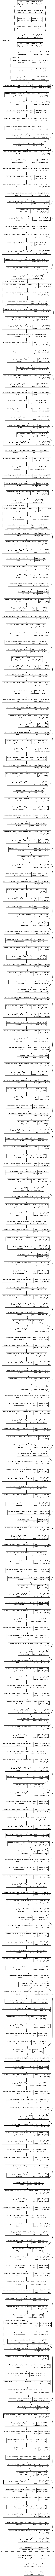

In [ ]:
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Define two callback functions for early stopping and learning rate reduction
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=10, min_lr=1e-5, mode='max')
]

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #Check
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
history = model.fit(
    X_train1,
    y_train1,
    validation_data=(X_val,y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=callbacks
).history

Epoch 1/200
72/72 [==============================] - 51s 295ms/step - loss: 0.6324 - binary_accuracy: 0.6318 - val_loss: 0.5176 - val_binary_accuracy: 0.7011 - lr: 0.0010
Epoch 2/200
72/72 [==============================] - 9s 122ms/step - loss: 0.4936 - binary_accuracy: 0.7407 - val_loss: 0.4436 - val_binary_accuracy: 0.7696 - lr: 0.0010
Epoch 3/200
72/72 [==============================] - 8s 112ms/step - loss: 0.4585 - binary_accuracy: 0.7625 - val_loss: 0.4489 - val_binary_accuracy: 0.7528 - lr: 0.0010
Epoch 4/200
72/72 [==============================] - 9s 119ms/step - loss: 0.4182 - binary_accuracy: 0.7955 - val_loss: 0.3991 - val_binary_accuracy: 0.7989 - lr: 0.0010
Epoch 5/200
72/72 [==============================] - 8s 115ms/step - loss: 0.4108 - binary_accuracy: 0.7951 - val_loss: 0.4019 - val_binary_accuracy: 0.7877 - lr: 0.0010
Epoch 6/200
72/72 [==============================] - 8s 116ms/step - loss: 0.3930 - binary_accuracy: 0.8106 - val_loss: 0.3891 - val_binary_accuracy:

In [ ]:
# Save the trained model
model.save('build_ConvNeXtLargeVer4')
del model

### Fine-tuning phase

In the first training stage, the ConvNeXt-Large backbone is **frozen** and only
the newly added classification head is trained. Once the classifier has converged,
we optionally **unfreeze the last convolutional blocks** of the backbone and
fine-tune them with a very low learning rate.

This two-stage procedure helps:
- preserve the general features learned on ImageNet
- adapt the deepest layers of the network to the plant health classification task
- reduce the risk of overfitting on a relatively small dataset


In [ ]:
model = tfk.models.load_model('build_ConvNeXtLargeVer4')

In [ ]:
%pip install colorama

### Localization of convolutional blocks

To fine-tune only part of the ConvNeXt-Large backbone, we inspect its internal
layers and identify the indices of the convolutional blocks that we want to unfreeze.


In [ ]:
import colorama
from colorama import Fore, Style

#Extracting all convolutional layers
for i, layer in enumerate(model.get_layer('convnext_large').layers):
    if 'conv' in layer.name:
        print(f"{Fore.BLUE}Layer {i}: {layer.name}, {layer.trainable}{Style.RESET_ALL}")
    else:
        print(f"Layer {i}: {layer.name}, {layer.trainable}")

Layer 0: input_1, True
Layer 1: convnext_large_prestem_normalization, False
Layer 2: convnext_large_stem, False
Layer 3: convnext_large_stage_0_block_0_depthwise_conv, False
Layer 4: convnext_large_stage_0_block_0_layernorm, False
Layer 5: convnext_large_stage_0_block_0_pointwise_conv_1, False
Layer 6: convnext_large_stage_0_block_0_gelu, False
Layer 7: convnext_large_stage_0_block_0_pointwise_conv_2, False
Layer 8: convnext_large_stage_0_block_0_layer_scale, False
Layer 9: convnext_large_stage_0_block_0_identity, False
Layer 10: tf.__operators__.add, False
Layer 11: convnext_large_stage_0_block_1_depthwise_conv, False
Layer 12: convnext_large_stage_0_block_1_layernorm, False
Layer 13: convnext_large_stage_0_block_1_pointwise_conv_1, False
Layer 14: convnext_large_stage_0_block_1_gelu, False
Layer 15: convnext_large_stage_0_block_1_pointwise_conv_2, False
Layer 16: convnext_large_stage_0_block_1_layer_scale, False
Layer 17: convnext_large_stage_0_block_1_identity, False
Layer 18: tf.__

##### Loop for selective fine-tuning

In the cell below we freeze all layers before a chosen index (`index_from`) so
that only the last ConvNeXt blocks are updated during fine-tuning.


In [ ]:
model.get_layer('convnext_large').trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 gaussian_noise (GaussianNo  (None, 96, 96, 3)         0         
 ise)                                                            
                                                                 
 convnext_large (Functional  (None, 3, 3, 1536)        196230336 
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [ ]:
# Freeze all layers up to the selected convolutional block index
index_from = 52
index_to = len(model.get_layer('convnext_large').layers)

for i, layer in enumerate(model.get_layer('convnext_large').layers):
    if i < index_from:  # freeze all layers before index_from
        layer.trainable = False
    # else:
    #     # Example variant: freeze only BatchNormalization layers above the indicated index
    #     if isinstance(layer, keras.layers.BatchNormalization):
    #         layer.trainable = False


In [ ]:
for i, layer in enumerate(model.get_layer('convnext_large').layers):
  if layer.trainable == True:
    print(i, layer.name, layer.trainable)

213 convnext_large_stage_2_block_20_depthwise_conv True
214 convnext_large_stage_2_block_20_layernorm True
215 convnext_large_stage_2_block_20_pointwise_conv_1 True
216 convnext_large_stage_2_block_20_gelu True
217 convnext_large_stage_2_block_20_pointwise_conv_2 True
218 convnext_large_stage_2_block_20_layer_scale True
219 convnext_large_stage_2_block_20_identity True
220 tf.__operators__.add_26 True
221 convnext_large_stage_2_block_21_depthwise_conv True
222 convnext_large_stage_2_block_21_layernorm True
223 convnext_large_stage_2_block_21_pointwise_conv_1 True
224 convnext_large_stage_2_block_21_gelu True
225 convnext_large_stage_2_block_21_pointwise_conv_2 True
226 convnext_large_stage_2_block_21_layer_scale True
227 convnext_large_stage_2_block_21_identity True
228 tf.__operators__.add_27 True
229 convnext_large_stage_2_block_22_depthwise_conv True
230 convnext_large_stage_2_block_22_layernorm True
231 convnext_large_stage_2_block_22_pointwise_conv_1 True
232 convnext_large_stage_

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 gaussian_noise (GaussianNo  (None, 96, 96, 3)         0         
 ise)                                                            
                                                                 
 convnext_large (Functional  (None, 3, 3, 1536)        196230336 
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [ ]:
# Define two callback functions for early stopping and learning rate reduction
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-5, mode='min')
]

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-6),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [ ]:
epochs = 10
batch_size = 32

baseline_history = model.fit(
    X_train2,
    y_train2,
    validation_data=(X_val,y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=callbacks
).history

Epoch 1/10
18/18 [==============================] - 162s 2s/step - loss: 0.4166 - binary_accuracy: 0.8176 - val_loss: 0.2862 - val_binary_accuracy: 0.8729 - lr: 1.0000e-06
Epoch 2/10
18/18 [==============================] - 7s 382ms/step - loss: 0.3681 - binary_accuracy: 0.8281 - val_loss: 0.2813 - val_binary_accuracy: 0.8785 - lr: 1.0000e-06
Epoch 3/10
18/18 [==============================] - 6s 358ms/step - loss: 0.4179 - binary_accuracy: 0.8063 - val_loss: 0.2789 - val_binary_accuracy: 0.8785 - lr: 1.0000e-06
Epoch 4/10
18/18 [==============================] - 6s 364ms/step - loss: 0.3741 - binary_accuracy: 0.8316 - val_loss: 0.2774 - val_binary_accuracy: 0.8799 - lr: 1.0000e-06
Epoch 5/10
18/18 [==============================] - 6s 363ms/step - loss: 0.3856 - binary_accuracy: 0.8421 - val_loss: 0.2757 - val_binary_accuracy: 0.8785 - lr: 1.0000e-06
Epoch 6/10
18/18 [==============================] - 6s 338ms/step - loss: 0.3449 - binary_accuracy: 0.8360 - val_loss: 0.2743 - val_bina

In [ ]:
# Save the trained model
model.save('ConvNeXtLargeVer4FineTuning')


### Performance on the Test Set

We evaluate the final fine-tuned model on the held-out test set, reporting
accuracy, precision, recall, F1-score and the confusion matrix.


Accuracy: 0.8771
Precision: 0.8775
Recall: 0.8771
F1: 0.8771


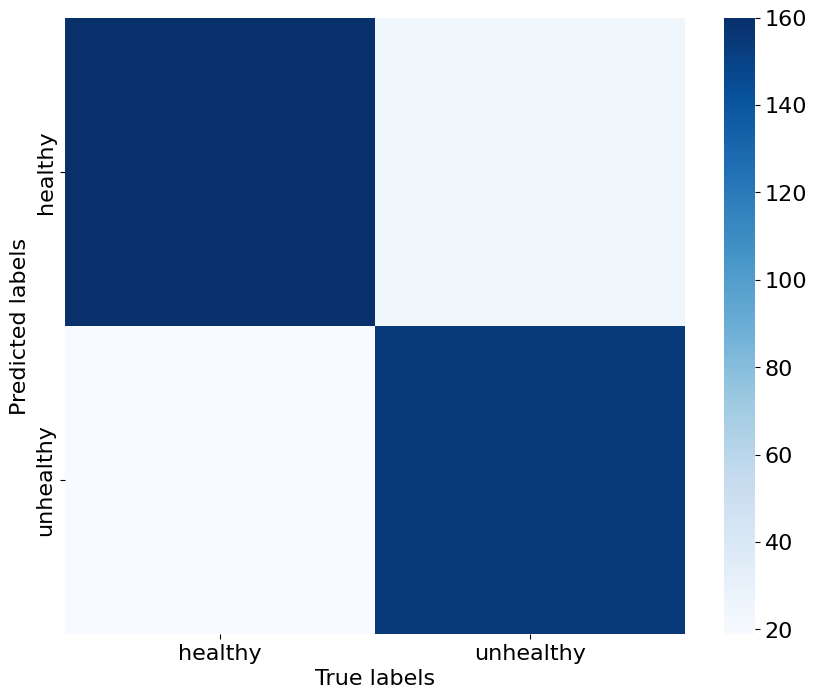

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))


# Plot the confusion matrix
plt.figure(figsize=(10, 8))
labels = {0:'healthy',1:'unhealthy'}
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()